In [1]:
## Import Packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras import initializers
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Concatenate, Reshape, Multiply, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from time import time
import sys, os, argparse
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.decomposition import PCA
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('talk')

## Read in toronto user-item interaction csv file to generate dataset:

In [2]:
toronto_user_item_final_df = pd.read_csv('yelp_dataset/toronto_user_item_final_df.csv', index_col = 0)
dataset_to_use = toronto_user_item_final_df.copy()

In [3]:
num_users = dataset_to_use.user_id.nunique()
num_items = dataset_to_use.business_id.nunique()

In [4]:
len(dataset_to_use)

227663

In [5]:
print('There are %d unique users and %d unique items in the dataset after filtering such that each user has \
reviewed at least 10 restaurants.'%(num_users, num_items))

There are 7905 unique users and 8546 unique items in the dataset after filtering such that each user has reviewed at least 10 restaurants.


In [6]:
dataset_to_use.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,1262 Don Mills Road,toronto,ON,M3B 2W7,43.744703,-79.346468,5.0,317,...,1,0,0,0,0,1,0,0,0,0
1,gAxeeJKwJtxp3uH9zUQ2aQ,A-Game Cafe,797 Dundas Street W,toronto,ON,M6J 1V2,43.651719,-79.407911,4.5,91,...,1,0,0,0,0,1,0,0,0,0
2,cWPTOM_o5toaXpq0gNxD7Q,Vanta Coffee Club & Eatery,2101 Brimley Road,toronto,ON,M1S 2B4,43.788839,-79.268636,4.0,204,...,1,0,0,0,0,1,0,0,0,0


### Create simpler IDs for users and items

In [7]:
unique_business_id = dataset_to_use.business_id.unique()
mapping_business_id = {}
ctr = 0
for business_id in unique_business_id:
    mapping_business_id[business_id] = ctr
    ctr += 1
    
dataset_to_use['business_id_refined'] = dataset_to_use.business_id.map(mapping_business_id)

In [8]:
unique_user_id = dataset_to_use.user_id.unique()
mapping_user_id = {}
ctr = 0
for user_id in unique_user_id:
    mapping_user_id[user_id] = ctr
    ctr += 1
    
dataset_to_use['user_id_refined'] = dataset_to_use.user_id.map(mapping_user_id)

In [9]:
dataset_to_use[['user_id_refined', 'business_id_refined']].head(5)

,user_id_refined,business_id_refined
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


# User Attributes:

### Choose top n each to be final features.
#### Smallest n for # final features>=60

In [10]:
import csv
Dish, Ingre = {}, {}

with open("Dish20000.csv", "r") as csvFile:
    reader = csv.reader(csvFile)
    for item in reader:
        Dish[item[0]] = int(item[1])
        
with open("Ingre20000.csv", "r") as csvFile:
    reader = csv.reader(csvFile)
    for item in reader:
        Ingre[item[0]] = int(item[1])

Dish = dict(sorted(Dish.items(), key=lambda item: item[1], reverse=1))
Ingre = dict(sorted(Ingre.items(), key=lambda item: item[1], reverse=1))

In [11]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def constructFeature(n_lim,Dish,Ingre):
    wnl = WordNetLemmatizer()

    n = int(n_lim/2)
    features = set()

    while len(features)<n_lim:
        n+=1
        features = set(list(Dish.keys())[:n]+list(Ingre.keys())[:n])
        features = set([str.lower(wrd) for wrd in features])
        features = set([wnl.lemmatize(wrd) for wrd in features]) # singluarization
        
    # Word "breakfast" not detected. Add to list.
    features = list(features) + ['breakfast']
    
    return features

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\somani4\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
n_lim = 9
features = constructFeature(n_lim,Dish,Ingre)
print(features)
num_of_user_features = len(features)
print(num_of_user_features)

['soup', 'sushi', 'salad', 'fry', 'dinner', 'bowl', 'beer', 'lunch', 'fish', 'breakfast']
10


In [13]:
user_features = np.zeros([num_users, len(features)])

for i in range(num_users):
    user_reviews = list(dataset_to_use[dataset_to_use.user_id_refined == i]['text'])
    for j in range(len(features)):
        for k in range(len(user_reviews)):
            review_temp = user_reviews[k].lower()
            if features[j] in review_temp:
                user_features[i,j] = 1
                
user_features.shape

(7905, 10)

In [15]:
user_features_df=pd.DataFrame(data = user_features, columns = ['user_feature_' + str(i) for i in range(num_of_user_features)])
user_features_df.index.rename('user_id_refined', inplace = True)
user_features_df.reset_index(inplace = True)
user_features_df.head(3)

,user_id_refined,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8,user_feature_9
0,0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [16]:
dataset_to_use = pd.merge(dataset_to_use, user_features_df, how = 'inner', on = 'user_id_refined')
dataset_to_use[['user_id_refined','business_id_refined']+['user_feature_'+str(i) for i in range(n_lim)]].head()

,user_id_refined,business_id_refined,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8
0,0,0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0,2,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0,3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0,4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [17]:
dataset_to_use.sort_values(by = ['user_id_refined', 'date'], inplace = True)
dataset_to_use.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8,user_feature_9
12,e49eXgKVuR-lsL0-D4vzDw,Momiji,2111 Sheppard Avenue E,toronto,ON,M2J 1W6,43.775377,-79.333972,3.0,22,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
10,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,1310 Don Mills Road,toronto,ON,M3B 2W6,43.745920,-79.346301,3.5,119,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,Nz44ccUso3nq5S2OlQHNlA,Mexico Lindo,"2600 Birchmount Road, Suite 2586",toronto,ON,M1T 2M5,43.789719,-79.302981,4.0,163,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


## Test Data:

In [18]:
def last_value(df):
    return df.iloc[[-1]]

In [19]:
# Save the most recent visit to a restaurant as the test data
test_data = dataset_to_use.groupby('user_id_refined').apply(last_value)

In [20]:
test_data.head(3)

,,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8,user_feature_9
user_id_refined,,,,,,,,,,,,,,,,,,,,,,
0,0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,1262 Don Mills Road,toronto,ON,M3B 2W7,43.744703,-79.346468,5.0,317,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,21,B70iTJjcPkuYn8ouUewWgw,Gusto 101,101 Portland Street,toronto,ON,M5V 2N3,43.645002,-79.400309,4.0,956,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,70,mVVoK2ADlKbvwitSqFY2hw,Pantry Foods,3456 Bathurst Street,toronto,ON,M6A 2C3,43.728130,-79.432020,4.0,20,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [21]:
dataset_to_use.query('user_id_refined == 0')['business_id_refined'].iloc[-1],\
dataset_to_use.query('user_id_refined == 1')['business_id_refined'].iloc[-1],\
dataset_to_use.query('user_id_refined == 2')['business_id_refined'].iloc[-1]

(0, 19, 64)

In [22]:
test_data = test_data.droplevel(0)
test_data.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8,user_feature_9
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,1262 Don Mills Road,toronto,ON,M3B 2W7,43.744703,-79.346468,5.0,317,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
21,B70iTJjcPkuYn8ouUewWgw,Gusto 101,101 Portland Street,toronto,ON,M5V 2N3,43.645002,-79.400309,4.0,956,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
70,mVVoK2ADlKbvwitSqFY2hw,Pantry Foods,3456 Bathurst Street,toronto,ON,M6A 2C3,43.728130,-79.432020,4.0,20,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [24]:
X_test = np.array(test_data[['user_id_refined', 'business_id_refined'] +\
                            ['user_feature_' + str(i) for i in range(num_of_user_features)]].values.tolist())
X_test

array([[0.000e+00, 0.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.000e+00, 1.900e+01, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [2.000e+00, 6.400e+01, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       ...,
       [7.902e+03, 1.841e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [7.903e+03, 9.300e+02, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.904e+03, 2.265e+03, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [25]:
X_test.shape

(7905, 12)

In [26]:
y_test = np.array(test_data['stars']) / 5.0
y_test

array([1. , 0.6, 1. , ..., 0.8, 0.2, 0.2])

In [27]:
len(y_test) == len(X_test)

True

In [28]:
y_test_one_hot = pd.get_dummies(pd.DataFrame({'rating': list(map(lambda x: str(x), y_test * 5.0))}))
y_test_one_hot.head(5)

,rating_1.0,rating_2.0,rating_3.0,rating_4.0,rating_5.0
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,0,0,1
3,0,0,0,1,0
4,0,0,0,1,0


In [29]:
len(y_test_one_hot) == len(y_test)

True

## Train Data:

In [30]:
# Save all visits to a restaurant except the last one as the train data
def all_values_except_last(df):
    return df.iloc[:-1]

In [31]:
train_data = dataset_to_use.groupby('user_id_refined').apply(all_values_except_last)

In [32]:
train_data = train_data.droplevel(0)
train_data.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8,user_feature_9
12,e49eXgKVuR-lsL0-D4vzDw,Momiji,2111 Sheppard Avenue E,toronto,ON,M2J 1W6,43.775377,-79.333972,3.0,22,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
10,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,1310 Don Mills Road,toronto,ON,M3B 2W6,43.745920,-79.346301,3.5,119,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,Nz44ccUso3nq5S2OlQHNlA,Mexico Lindo,"2600 Birchmount Road, Suite 2586",toronto,ON,M1T 2M5,43.789719,-79.302981,4.0,163,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [33]:
len(train_data), len(test_data), len(train_data) + len(test_data) == len(dataset_to_use)

(219758, 7905, True)

In [34]:
X_train = np.array(train_data[['user_id_refined','business_id_refined'] +\
                             ['user_feature_' + str(i) for i in range(n_lim + 1)]].values.tolist())
X_train

array([[0.000e+00, 1.200e+01, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [0.000e+00, 1.000e+01, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [0.000e+00, 3.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [7.904e+03, 8.045e+03, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [7.904e+03, 8.480e+03, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [7.904e+03, 6.951e+03, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [35]:
X_train.shape

(219758, 12)

In [36]:
y_train = np.array(train_data['stars']) / 5.0
y_train

array([0.6, 0.6, 1. , ..., 0.6, 0.4, 0.2])

In [37]:
len(y_train) == len(X_train)

True

In [38]:
y_train_one_hot = pd.get_dummies(pd.DataFrame({'rating': list(map(lambda x: str(x), y_train * 5.0))}))
y_train_one_hot.head(5)

,rating_1.0,rating_2.0,rating_3.0,rating_4.0,rating_5.0
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,1,0


In [39]:
len(y_train_one_hot) == len(y_train)

True

# (1) GMF Implementation:

In [40]:
#################### Arguments ####################
# def parse_args():
#     parser = argparse.ArgumentParser(description="Run GMF.")
    
#     parser.add_argument('--epochs', type=int, default=100,
#                         help='Number of epochs.')
#     parser.add_argument('--batch_size', type=int, default=256,
#                         help='Batch size.')
#     parser.add_argument('--num_factors', type=int, default=8,
#                         help='Embedding size.')
#     parser.add_argument('--regs', nargs='?', default='[0,0]',
#                         help="Regularization for user and item embeddings.")
#     parser.add_argument('--lr', type=float, default=0.001,
#                         help='Learning rate.')
#     parser.add_argument('--learner', nargs='?', default='adam',
#                         help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
#     parser.add_argument('--verbose', type=int, default=1,
#                         help='Show performance per X iterations')
#     parser.add_argument('--out', type=int, default=1,
#                         help='Whether to save the trained model.')
#     return parser.parse_args()

# sys.argv = ['GMF.py','--epochs','10','--batch_size','256','--num_factors','8',
# '--regs','[0,0]', '--lr','0.001','--learner','adam','--verbose','1','--out','1']

# args = parse_args()
# num_factors = args.num_factors
# regs = eval(args.regs)
# learner = args.learner
# learning_rate = args.lr
# num_epochs = args.epochs
# batch_size = args.batch_size
# verbose = args.verbose

# print("GMF arguments: %s" %(args))

In [77]:
def get_gmf_model(num_users, num_items, latent_dim, regs = [0,0]):
    # Input variables
    user_input = Input(shape=(1,), dtype='float32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='float32', name = 'item_input')
    user_feature_input = Input(shape = (num_of_user_features, ), dtype='float32', name = 'user_feature_input')
    

    MF_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = num_of_user_features, name = 'user_embedding',
                                  embeddings_initializer='random_normal', embeddings_regularizer = l2(regs[0]),
                                  input_length = 1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = num_of_user_features, name = 'item_embedding',
                                  embeddings_initializer='random_normal', embeddings_regularizer = l2(regs[1]),
                                  input_length = 1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User_ID(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user_latent and user_feature_input
    user_feature_latent = Multiply()([user_latent, user_feature_input])
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_feature_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(inputs = [user_input, item_input, user_feature_input], outputs = prediction)

    return model

def get_train_instances(X, y):
    X = np.array(X)
    users, items, user_features = X[:, 0], X[:, 1], X[:, 2:]
    ratings = y
    
    return users, items, user_features, ratings

In [81]:
def evaluate_model(model, X, y):
    """
    Return: score of each test rating.
    """
    users, items, user_features, ratings = get_train_instances(X, y)
    
    #print(users.shape, items.shape, user_features.shape)
        
    predictions = model.predict([users, items, user_features], batch_size = 1000, verbose = 0)

    y_actual = np.array(y) * 5
    y_pred = np.array(predictions) * 5
    assert len(y_pred) == len(y_actual)
    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    
    return (mse, r2)

In [84]:
# Build model
num_factors = 8
regs = [0, 0]
learner = 'adam'
learning_rate = 0.0005
num_epochs = 20
batch_size = 256
out = 1

model = get_gmf_model(num_users, num_items, num_factors, regs)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Initial: Test RMSE = 1.7351, Test R2 = -0.8242


C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [1.2 s]: Test RMSE = 1.4633, Test R2 = -0.2976, Train Loss = 0.0816 [0.0 s]
Epoch 2 [0.8 s]: Test RMSE = 1.3401, Test R2 = -0.0882, Train Loss = 0.0596 [0.0 s]
Epoch 3 [0.8 s]: Test RMSE = 1.2960, Test R2 = -0.0177, Train Loss = 0.0516 [0.0 s]
Epoch 4 [0.8 s]: Test RMSE = 1.2788, Test R2 = 0.0091, Train Loss = 0.0479 [0.0 s]
Epoch 5 [0.7 s]: Test RMSE = 1.2688, Test R2 = 0.0245, Train Loss = 0.0447 [0.1 s]
Epoch 6 [0.9 s]: Test RMSE = 1.2623, Test R2 = 0.0345, Train Loss = 0.0415 [0.1 s]
Epoch 7 [0.9 s]: Test RMSE = 1.2590, Test R2 = 0.0395, Train Loss = 0.0385 [0.1 s]
Epoch 8 [1.2 s]: Test RMSE = 1.2585, Test R2 = 0.0403, Train Loss = 0.0358 [0.1 s]
Epoch 9 [1.1 s]: Test RMSE = 1.2605, Test R2 = 0.0372, Train Loss = 0.0336 [0.1 s]
Epoch 10 [0.9 s]: Test RMSE = 1.2650, Test R2 = 0.0304, Train Loss = 0.0316 [0.1 s]
Epoch 11 [0.8 s]: Test RMSE = 1.2704, Test R2 = 0.0221, Train Loss = 0.0300 [0.1 s]
Epoch 12 [0.9 s]: Test RMSE = 1.2779, Test R2 = 0.0105, Train Loss = 0.0287 [0.1 s

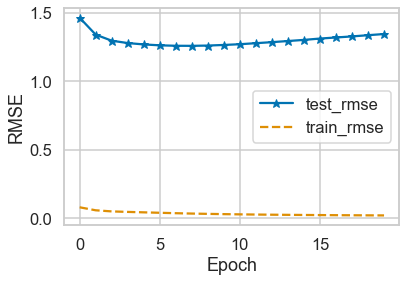

In [85]:
# Training and testing model
current_folder = os.getcwd()
model_out_file_gmf = current_folder + '\\Pretrain\\toronto_GMF.h5'

train_loss = []
test_rmse, test_r2 = [], []
best_mse = float('inf')

for epoch in range(num_epochs):
    t1 = time()
    
    # Generate training instances
    user_input, item_input, user_feature_input, ratings = get_train_instances(X_train, y_train)
    
    # Training
    history = model.fit([user_input, item_input, user_feature_input], # input
                         np.array(ratings), # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(history.history['loss'][0])
    
    t2 = time()

    # Evaluation
    
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train Loss = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch + 1
        if out > 0:
            model.save_weights(model_out_file_gmf, overwrite = True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best GMF model is saved")
    
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

# (2) MLP Implementation:

In [37]:
# def parse_args():
#     parser = argparse.ArgumentParser(description="Run MLP.")
    
#     parser.add_argument('--epochs', type=int, default=100,
#                         help='Number of epochs.')
#     parser.add_argument('--batch_size', type=int, default=256,
#                         help='Batch size.')
#     parser.add_argument('--layers', nargs='?', default='[64,32,16,8]',
#                         help="Size of each layer. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size.")
#     parser.add_argument('--reg_layers', nargs='?', default='[0,0,0,0]',
#                         help="Regularization for each layer")
#     parser.add_argument('--lr', type=float, default=0.001,
#                         help='Learning rate.')
#     parser.add_argument('--learner', nargs='?', default='adam',
#                         help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
#     parser.add_argument('--verbose', type=int, default=1,
#                         help='Show performance per X iterations')
#     parser.add_argument('--out', type=int, default=1,
#                         help='Whether to save the trained model.')
#     return parser.parse_args()

# sys.argv = ['MLP.py','--epochs','5','--batch_size','256','--layers',str(list(np.array([64,32,16,8]) * 2)),
# '--reg_layers','[0,0,0,0]','--lr','0.001','--learner','adam','--verbose','1','--out','1']

# args = parse_args()
# layers = eval(args.layers)
# reg_layers = eval(args.reg_layers)
# learner = args.learner
# learning_rate = args.lr
# batch_size = args.batch_size
# num_epochs = args.epochs
# verbose = args.verbose
# evaluation_threads = -1 # mp.cpu_count()

# print("MLP arguments: %s" %(args))

In [92]:
def get_mlp_model(num_users, num_items, layers = [20,10], reg_layers=[0,0]):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='float32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='float32', name = 'item_input')
    user_feature_input = Input(shape = (num_of_user_features, ), dtype='float32', name = 'user_feature_input')
    
    MLP_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = num_of_user_features, name = 'user_ID_embedding',
                                   embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = num_of_user_features, name = 'item_embedding',
                                   embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User_ID(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # Element-wise product of user_latent and user_feature_input
    user_feature_latent = Multiply()([user_latent, user_feature_input])
    
    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate()([user_feature_latent, item_latent])
    
    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer = l2(reg_layers[idx]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(vector)
    model = Model(inputs = [user_input, item_input, user_feature_input], outputs = prediction)
    
    return model

In [93]:
# Build model
layers = [64,32,16,8]
reg_layers = [0,0,0,0]

model = get_mlp_model(num_users, num_items, layers, reg_layers)

if learner.lower() == "adagrad":
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Initial: Test RMSE = 1.7332, Test R2 = -0.8202


C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [1.4 s]: Test RMSE = 1.1970, Test R2 = 0.1318, Train Loss = 0.2231 [0.0 s]
Epoch 2 [1.0 s]: Test RMSE = 1.1694, Test R2 = 0.1713, Train Loss = 0.1974 [0.1 s]
Epoch 3 [1.0 s]: Test RMSE = 1.1616, Test R2 = 0.1824, Train Loss = 0.1927 [0.0 s]
Epoch 4 [1.0 s]: Test RMSE = 1.1580, Test R2 = 0.1875, Train Loss = 0.1906 [0.0 s]
Epoch 5 [1.0 s]: Test RMSE = 1.1569, Test R2 = 0.1890, Train Loss = 0.1891 [0.1 s]
Epoch 6 [1.0 s]: Test RMSE = 1.1550, Test R2 = 0.1917, Train Loss = 0.1876 [0.0 s]
Epoch 7 [1.1 s]: Test RMSE = 1.1598, Test R2 = 0.1849, Train Loss = 0.1858 [0.1 s]
Epoch 8 [1.1 s]: Test RMSE = 1.1595, Test R2 = 0.1853, Train Loss = 0.1836 [0.1 s]
Epoch 9 [1.1 s]: Test RMSE = 1.1634, Test R2 = 0.1799, Train Loss = 0.1810 [0.1 s]
Epoch 10 [1.2 s]: Test RMSE = 1.1737, Test R2 = 0.1653, Train Loss = 0.1782 [0.1 s]
Epoch 11 [1.2 s]: Test RMSE = 1.1794, Test R2 = 0.1571, Train Loss = 0.1752 [0.1 s]
Epoch 12 [1.0 s]: Test RMSE = 1.1885, Test R2 = 0.1440, Train Loss = 0.1722 [0.1 s]
E

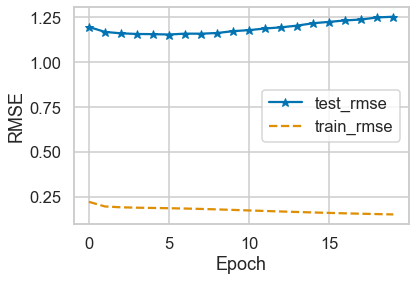

In [94]:
# Training and testing model
current_folder = os.getcwd()
model_out_file_mlp = current_folder + '\\Pretrain\\toronto_MLP.h5'

train_loss = []
test_rmse, test_r2 = [], []
best_mse = float('inf')

for epoch in range(num_epochs):
    t1 = time()
    
    # Generate training instances
    user_input, item_input, user_feature_input, ratings = get_train_instances(X_train, y_train)
    
    # Training
    history = model.fit([user_input, item_input, user_feature_input], # input
                         np.array(ratings), # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]))
    
    t2 = time()

    # Evaluation
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train Loss = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch + 1
        if out > 0:
            model.save_weights(model_out_file_mlp, overwrite = True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best MLP model is saved")
    
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

# NCF Implementation:

In [41]:
# #################### Arguments ####################
# def parse_args():
#     parser = argparse.ArgumentParser(description="Run NeuMF.")
    
#     parser.add_argument('--epochs', type=int, default=100,
#                         help='Number of epochs.')
#     parser.add_argument('--batch_size', type=int, default=256,
#                         help='Batch size.')
#     parser.add_argument('--num_factors', type=int, default=8,
#                         help='Embedding size of MF model.')
#     parser.add_argument('--layers', nargs='?', default='[64,32,16,8]',
#                         help="MLP layers. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size.")
#     parser.add_argument('--reg_mf', type=float, default=0,
#                         help='Regularization for MF embeddings.')                    
#     parser.add_argument('--reg_layers', nargs='?', default='[0,0,0,0]',
#                         help="Regularization for each MLP layer. reg_layers[0] is the regularization for embeddings.")
#     parser.add_argument('--lr', type=float, default=0.001,
#                         help='Learning rate.')
#     parser.add_argument('--learner', nargs='?', default='adam',
#                         help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
#     parser.add_argument('--verbose', type=int, default=1,
#                         help='Show performance per X iterations')
#     parser.add_argument('--out', type=int, default=1,
#                         help='Whether to save the trained model.')
#     parser.add_argument('--mf_pretrain', nargs='?', default='',
#                         help='Specify the pretrain model file for MF part. If empty, no pretrain will be used')
#     parser.add_argument('--mlp_pretrain', nargs='?', default='',
#                         help='Specify the pretrain model file for MLP part. If empty, no pretrain will be used')
#     return parser.parse_args()


# sys.argv = ['NeuMF.py','--epochs','10','--batch_size','256','--num_factors','8',
#             '--layers','[128,64,32,16]','--reg_mf','0','--reg_layers','[0,0,0,0]',
#             '--lr','0.0005','--learner','adam','--verbose','1','--out','1',
#             '--mf_pretrain', model_out_file_gmf, '--mlp_pretrain', model_out_file_mlp] # '[64,32,16,8]'

# args = parse_args()

In [42]:
def get_ncf_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    fan_input = Input(shape=(1,), dtype='int32', name = 'fan_input')
    
    print('Input layer: ', user_input.shape, user_input.dtype, fan_input.shape)
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_embedding_user',
                                  embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = mf_dim, name = 'mf_embedding_item',
                                  embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)  
    MF_Embedding_Fan = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_fan_embedding',
                                  embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)
    

    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = int(layers[0]/2), name = "mlp_embedding_user",
                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = int(layers[0]/2), name = 'mlp_embedding_item',
                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Fan = Embedding(input_dim = num_users, output_dim = int(layers[0]/2), name = 'mlp_fan_embedding',
                                  embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                  input_length=1)

    output = MLP_Embedding_User(user_input)
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_fan_latent = Flatten()(MF_Embedding_Fan(fan_input))
    
    mf_vector = Multiply()([mf_user_latent, mf_item_latent, mf_fan_latent]) # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_fan_latent = Flatten()(MLP_Embedding_Fan(fan_input))
    
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent, mlp_fan_latent])
    
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation = 'sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)
    
    model = Model(inputs = [user_input, item_input, fan_input], outputs = prediction)
    
    return model

def load_pretrain_model(model, gmf_model, mlp_model, num_layers):
    # MF embeddings
    gmf_user_embeddings = gmf_model.get_layer('user_embedding').get_weights()
    gmf_item_embeddings = gmf_model.get_layer('item_embedding').get_weights()
    model.get_layer('mf_embedding_user').set_weights(gmf_user_embeddings)
    model.get_layer('mf_embedding_item').set_weights(gmf_item_embeddings)
    
    # MLP embeddings
    mlp_user_embeddings = mlp_model.get_layer('user_embedding').get_weights()
    mlp_item_embeddings = mlp_model.get_layer('item_embedding').get_weights()
    model.get_layer('mlp_embedding_user').set_weights(mlp_user_embeddings)
    model.get_layer('mlp_embedding_item').set_weights(mlp_item_embeddings)
    
    # MLP layers
    for i in range(1, num_layers):
        mlp_layer_weights = mlp_model.get_layer('layer%d' %i).get_weights()
        model.get_layer('layer%d' %i).set_weights(mlp_layer_weights)
        
    # Prediction weights
    gmf_prediction = gmf_model.get_layer('prediction').get_weights()
    mlp_prediction = mlp_model.get_layer('prediction').get_weights()
    new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
    new_b = gmf_prediction[1] + mlp_prediction[1]
    model.get_layer('prediction').set_weights([0.5*new_weights, 0.5*new_b])    
    return model

In [43]:
# Build and compile, and check initial performance
mf_dim = num_factors
layers = layers.copy()
reg_layers = reg_layers.copy()
reg_mf = 0
mf_pretrain = model_out_file_gmf
mlp_pretrain = model_out_file_mlp

model = get_ncf_model(num_users, num_items, mf_dim, layers, reg_layers, reg_mf)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Load pretrain model
if mf_pretrain != '' and mlp_pretrain != '':
    gmf_model = get_gmf_model(num_users,num_items,mf_dim)
    gmf_model.load_weights(mf_pretrain)
    mlp_model = get_mlp_model(num_users,num_items, layers, reg_layers)
    mlp_model.load_weights(mlp_pretrain)
    model = load_pretrain_model(model, gmf_model, mlp_model, len(layers))
    print("Load pretrained GMF (%s) and MLP (%s) models done. " %(mf_pretrain, mlp_pretrain))
    
# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Input layer:  (None, 1) <dtype: 'int32'> (None, 1)
Load pretrained GMF (C:\Users\somani4\Documents\GitHub\CS_412_Akhilesh_Folder\Pretrain\toronto_GMF.h5) and MLP (C:\Users\somani4\Documents\GitHub\CS_412_Akhilesh_Folder\Pretrain\toronto_MLP.h5) models done. 
Initial: Test RMSE = 1.1929, Test R2 = 0.1377


C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [3.8 s]: Test RMSE = 1.1503, Test R2 = 0.1983, Train Loss = 0.1882 [0.1 s]
Epoch 2 [3.4 s]: Test RMSE = 1.1526, Test R2 = 0.1950, Train Loss = 0.1813 [0.1 s]
Epoch 3 [3.4 s]: Test RMSE = 1.1705, Test R2 = 0.1698, Train Loss = 0.1712 [0.1 s]
Epoch 4 [3.3 s]: Test RMSE = 1.1938, Test R2 = 0.1364, Train Loss = 0.1600 [0.1 s]
Epoch 5 [3.2 s]: Test RMSE = 1.2180, Test R2 = 0.1011, Train Loss = 0.1500 [0.1 s]
Epoch 6 [3.2 s]: Test RMSE = 1.2409, Test R2 = 0.0669, Train Loss = 0.1408 [0.1 s]
Epoch 7 [3.3 s]: Test RMSE = 1.2624, Test R2 = 0.0343, Train Loss = 0.1323 [0.1 s]
Epoch 8 [3.4 s]: Test RMSE = 1.2873, Test R2 = -0.0041, Train Loss = 0.1246 [0.1 s]
Epoch 9 [3.2 s]: Test RMSE = 1.3034, Test R2 = -0.0294, Train Loss = 0.1175 [0.1 s]
Epoch 10 [3.4 s]: Test RMSE = 1.3205, Test R2 = -0.0566, Train Loss = 0.1113 [0.1 s]
End. Best Epoch 1:  RMSE = 1.1503, R2 = 0.1983. 
The best NeuMF model is saved


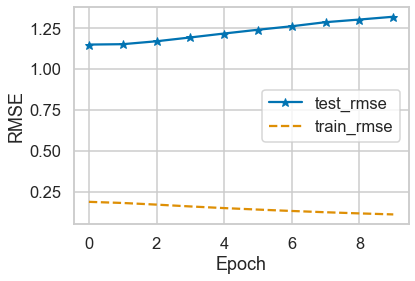

In [44]:
# Training and testing model
mf_dim = num_factors
layers = layers.copy()
reg_layers = reg_layers.copy()
reg_mf = 0
mf_pretrain = model_out_file_gmf
mlp_pretrain = model_out_file_mlp

current_folder = os.getcwd()
model_out_file_ncf = current_folder + '\\Pretrain\\toronto_NeuMF.h5'

train_loss, val_loss = [], []
test_rmse, test_r2 = [], []
best_mse = float('inf')

for epoch in range(num_epochs):
    t1 = time()
    
    # Generate training instances
    user_input, item_input, fan_input, ratings = get_train_instances(X_train, y_train)
    
    # Training
    history = model.fit([user_input, item_input, fan_input], # input
                         ratings, # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]))
    
    t2 = time()

    # Evaluation
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train Loss = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch
        if out > 0:
            model.save_weights(model_out_file_ncf, overwrite=True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter + 1, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best NeuMF model is saved")
    
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()